# Reading and analysing data from Yahoo Finance

Taking the functions from utils.py, to make the code more modular.

In [1]:
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
# logging level: NOTSET, DEBUG, INFO, WARNING, ERROR, CRITICAL
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [86]:
INPUT_FILE_NAME = "/Users/abuzatu/Work/data/finance/stocks/tickers7.txt"
OUTPUT_FOLDER_NAME = "/Users/abuzatu/Work/data/finance/stocks/processed_data"

In [4]:
ADD_OUTSIDE_TRADING_HOURS = True
ADD_DIVIDENDS_AND_STOCK_SPLITS = True
AUTO_ADJUST = True
PERIOD = None

In [12]:
LIST_DATE = [
        # ("10-01-01", "19-01-01", "1d"),
        ("19-01-01", "19-01-04", "1d"),
        ("19-01-04", "20-11-04", "1h"),
        ("20-11-04", "20-11-18", "5m"),
        ("20-11-18", "20-12-04", "2m"),
        ("20-12-04", "20-12-11", "1m"),
        ("20-12-11", "20-12-18", "1m"),
        ("20-12-18", "20-12-25", "1m"),
        ("20-12-25", "21-01-01", "1m"),
    ]
#LIST_DATE = [
#    ("19-01-01", "19-01-04", "1d"),
#]
date_start_all = LIST_DATE[0][0]
date_end_all = LIST_DATE[-1][-2]

In [13]:
date_start_all

'19-01-01'

In [14]:
date_end_all

'21-01-01'

In [6]:
INPUT_FILE_NAME

'/Users/abuzatu/Work/data/finance/stocks/tickers_bk.txt'

In [87]:
list_stock_ticker = []
try:
    f = open(INPUT_FILE_NAME)
    lines = f.readlines()
    for line in lines:
        line = line.rstrip()
        if line.startswith("#"):
            continue
        list_stock_ticker.append(line)
except IOError:
    print(f"File {INPUT_FILE_NAME} not accessible.")
finally:
    f.close()
list_stock_ticker

['DISH',
 'DVA',
 'DAN',
 'DRI',
 'MSP',
 'DXCM',
 'FANG',
 'DIN',
 'DISCK',
 'DG',
 'AMRX',
 'ARCC',
 'ASAN',
 'AZO']

In [88]:
def get_df(stock_ticker, list_date, output_folder_name):
    list_df = []
    for s, e, interval in list_date:
        string_date_start = f"20{s} 00:00:00"
        string_date_end   = f"20{e} 00:00:00"
        date_start = pd.to_datetime(string_date_start).tz_localize(LOCALIZE_US_STOCK_MARKET)
        date_end = pd.to_datetime(string_date_end).tz_localize(LOCALIZE_US_STOCK_MARKET)
        logger.info(f"{stock_ticker} from {date_start} to {date_end} with interval {interval}")
        # fix a bug in yfinance of not applying the localization when this option is on
        if ADD_OUTSIDE_TRADING_HOURS:
            date_start += pd.Timedelta (5, "h")
            date_end += pd.Timedelta (5, "h")

        # read the data
        df = read_data(stock_ticker,
                   PERIOD,
                   date_start,
                   date_end,
                   interval,
                   ADD_OUTSIDE_TRADING_HOURS,
                   ADD_DIVIDENDS_AND_STOCK_SPLITS,
                   AUTO_ADJUST)
        
        #
        logger.info(f"len = {len(df)}")
        if len(df) > 0:
            if stock_ticker == "AMRH":
                if interval.endswith("h") or interval.endswith("m"):
                    # ajust by the stock split of 4 stocks -> 1 stock
                    apply_split(df, 4, 1)
            # add to list
            list_df.append(df)
            # save for future
            output_file_name = get_output_file_name(output_folder_name, s, e, interval, stock_ticker)
            df.to_pickle(output_file_name )
                  
    # print(list_df[-1])
    return pd.concat(list_df, axis = 0)

In [89]:
# read the file and save to a file
for stock_ticker in list_stock_ticker:
    if False:
        # do only for one ticker
        if stock_ticker != "EOSE":
            continue
    print(f"stock_ticker={stock_ticker}")
    # find automatically the range that we want
    # we collect the data using the period max, then find the first date
    # than depending on that date build the LIST_DATE
    df = read_data(stock_ticker,
                   "max",
                   None,
                   None,
                   "1d",
                   ADD_OUTSIDE_TRADING_HOURS,
                   ADD_DIVIDENDS_AND_STOCK_SPLITS,
                   AUTO_ADJUST)
    datetime_end = df.index[0].tz_localize(None)
    date_short = str(datetime_end.tz_localize(None).date())[2:]
    list_date = []
    if datetime_end < pd.to_datetime("2019-01-01"):
        list_date = [
            ("19-01-01", "19-01-04", "1d"),
            ("19-01-04", "20-11-04", "1h"),
            ("20-11-04", "20-11-18", "5m"),
            ("20-11-18", "20-12-04", "2m"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2019-01-04"):
        list_date = [
            (date_short, "19-01-04", "1d"),
            ("19-01-04", "20-11-04", "1h"),
            ("20-11-04", "20-11-18", "5m"),
            ("20-11-18", "20-12-04", "2m"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2020-11-04"):
        list_date = [
            (date_short, "20-11-04", "1h"),
            ("20-11-04", "20-11-18", "5m"),
            ("20-11-18", "20-12-04", "2m"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2020-11-18"):
        list_date = [
            (date_short, "20-11-18", "5m"),
            ("20-11-18", "20-12-04", "2m"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2020-12-04"):
        list_date = [
            (date_short, "20-12-04", "2m"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2020-12-11"):
        list_date = [
            (date_short, "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2020-12-18"):
        list_date = [
            (date_short, "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2020-12-25"):
        list_date = [
            (date_short, "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    elif datetime_end < pd.to_datetime("2021-01-01"):
        list_date = [
            (date_short, "21-01-01", "1m"),
        ]
    
    if stock_ticker == "LAZR":
        list_date = [
            ("19-03-25", "20-12-04", "1d"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    if stock_ticker == "QS":
        list_date = [
            ("20-08-17", "20-12-04", "1d"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    if stock_ticker == "GOEV" or stock_ticker == "XL":
        list_date = [
            ("19-04-16", "20-12-18", "1d"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    if stock_ticker == "EOSE":
        list_date = [
            (date_short, "20-11-18", "1d"),
            ("20-11-18", "20-12-04", "2m"),
            ("20-12-04", "20-12-11", "1m"),
            ("20-12-11", "20-12-18", "1m"),
            ("20-12-18", "20-12-25", "1m"),
            ("20-12-25", "21-01-01", "1m"),
        ]
    
    if False:
        for date in list_date:
            print(date)
    #break
    # continue
    #
    logging.info(f"{stock_ticker}")
    df = get_df(stock_ticker, list_date, OUTPUT_FOLDER_NAME)
    output_file_name = get_output_file_name(OUTPUT_FOLDER_NAME, date_start_all, date_end_all, "al", stock_ticker)
    df.to_pickle(output_file_name)

stock_ticker=DISH


INFO:root:DISH
INFO:root:DISH from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DISH from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4442
INFO:root:DISH from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 874
INFO:root:DISH from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2151
INFO:root:DISH from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1930
INFO:root:DISH from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 2049
INFO:root:DISH from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1866
INFO:root:DISH from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1589


stock_ticker=DVA


INFO:root:DVA
INFO:root:DVA from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DVA from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4200
INFO:root:DVA from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 846
INFO:root:DVA from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2094
INFO:root:DVA from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1631
INFO:root:DVA from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1687
INFO:root:DVA from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1529
INFO:root:DVA from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1136


stock_ticker=DAN


INFO:root:DAN
INFO:root:DAN from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DAN from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4194
INFO:root:DAN from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 828
INFO:root:DAN from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2065
INFO:root:DAN from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1878
INFO:root:DAN from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1841
INFO:root:DAN from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1678
INFO:root:DAN from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1422


stock_ticker=DRI


INFO:root:DRI
INFO:root:DRI from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DRI from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4663
INFO:root:DRI from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 884
INFO:root:DRI from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2146
INFO:root:DRI from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1931
INFO:root:DRI from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1976
INFO:root:DRI from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1811
INFO:root:DRI from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1458
INFO:root:MSP
INFO:root:MSP from 2020-10-21 00:00:00-04:00 to 2020-11-04 00:00:00-05:00 with i

stock_ticker=MSP


INFO:root:len = 107
INFO:root:MSP from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 813
INFO:root:MSP from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 1896
INFO:root:MSP from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1428
INFO:root:MSP from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1616
INFO:root:MSP from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1429
INFO:root:MSP from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1040


stock_ticker=DXCM


INFO:root:DXCM
INFO:root:DXCM from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DXCM from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4464
INFO:root:DXCM from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 858
INFO:root:DXCM from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2122
INFO:root:DXCM from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1892
INFO:root:DXCM from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1834
INFO:root:DXCM from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1546
INFO:root:DXCM from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1368


stock_ticker=FANG


INFO:root:FANG
INFO:root:FANG from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:FANG from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 5246
INFO:root:FANG from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 1074
INFO:root:FANG from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2480
INFO:root:FANG from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 2098
INFO:root:FANG from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 2077
INFO:root:FANG from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1938
INFO:root:FANG from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1638


stock_ticker=DIN


INFO:root:DIN
INFO:root:DIN from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DIN from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4363
INFO:root:DIN from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 838
INFO:root:DIN from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 1829
INFO:root:DIN from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1308
INFO:root:DIN from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1171
INFO:root:DIN from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1157
INFO:root:DIN from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1227


stock_ticker=DISCK


INFO:root:DISCK
INFO:root:DISCK from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DISCK from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 3998
INFO:root:DISCK from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 811
INFO:root:DISCK from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2105
INFO:root:DISCK from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1960
INFO:root:DISCK from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1943
INFO:root:DISCK from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1765
INFO:root:DISCK from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1520


stock_ticker=DG


INFO:root:DG
INFO:root:DG from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:DG from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4610
INFO:root:DG from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 856
INFO:root:DG from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2293
INFO:root:DG from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1995
INFO:root:DG from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1973
INFO:root:DG from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1791
INFO:root:DG from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1542


stock_ticker=AMRX


INFO:root:AMRX
INFO:root:AMRX from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:AMRX from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4455
INFO:root:AMRX from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 860
INFO:root:AMRX from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2010
INFO:root:AMRX from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1441
INFO:root:AMRX from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1692
INFO:root:AMRX from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1235
INFO:root:AMRX from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1120


stock_ticker=ARCC


INFO:root:ARCC
INFO:root:ARCC from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:ARCC from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 4741
INFO:root:ARCC from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 860
INFO:root:ARCC from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2155
INFO:root:ARCC from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1962
INFO:root:ARCC from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1951
INFO:root:ARCC from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1763
INFO:root:ARCC from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1556


stock_ticker=ASAN


INFO:root:ASAN
INFO:root:ASAN from 2020-09-30 00:00:00-04:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 319
INFO:root:ASAN from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 868
INFO:root:ASAN from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 2337
INFO:root:ASAN from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 2555
INFO:root:ASAN from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 2048
INFO:root:ASAN from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 1815
INFO:root:ASAN from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 1498


stock_ticker=AZO


INFO:root:AZO
INFO:root:AZO from 2019-01-01 00:00:00-05:00 to 2019-01-04 00:00:00-05:00 with interval 1d
INFO:root:len = 2
INFO:root:AZO from 2019-01-04 00:00:00-05:00 to 2020-11-04 00:00:00-05:00 with interval 1h
INFO:root:len = 3992
INFO:root:AZO from 2020-11-04 00:00:00-05:00 to 2020-11-18 00:00:00-05:00 with interval 5m
INFO:root:len = 776
INFO:root:AZO from 2020-11-18 00:00:00-05:00 to 2020-12-04 00:00:00-05:00 with interval 2m
INFO:root:len = 1582
INFO:root:AZO from 2020-12-04 00:00:00-05:00 to 2020-12-11 00:00:00-05:00 with interval 1m
INFO:root:len = 1458
INFO:root:AZO from 2020-12-11 00:00:00-05:00 to 2020-12-18 00:00:00-05:00 with interval 1m
INFO:root:len = 1262
INFO:root:AZO from 2020-12-18 00:00:00-05:00 to 2020-12-25 00:00:00-05:00 with interval 1m
INFO:root:len = 932
INFO:root:AZO from 2020-12-25 00:00:00-05:00 to 2021-01-01 00:00:00-05:00 with interval 1m
INFO:root:len = 753


In [45]:
df

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2019-04-16 16:00:00-04:00,2019-04-16 09:30:00-04:00,9.84,9.85,9.82,9.84,770500
2019-04-17 16:00:00-04:00,2019-04-17 09:30:00-04:00,9.89,9.89,9.83,9.84,138100
2019-04-18 16:00:00-04:00,2019-04-18 09:30:00-04:00,9.87,10.34,9.84,9.84,21200
2019-04-22 16:00:00-04:00,2019-04-22 09:30:00-04:00,9.84,9.84,9.84,9.84,100
2019-04-23 16:00:00-04:00,2019-04-23 09:30:00-04:00,9.81,9.81,9.81,9.81,100
...,...,...,...,...,...,...
2020-12-31 19:25:00-05:00,2020-12-31 19:24:00-05:00,13.75,13.75,13.75,13.75,0
2020-12-31 19:26:00-05:00,2020-12-31 19:25:00-05:00,13.70,13.70,13.70,13.70,0
2020-12-31 19:29:00-05:00,2020-12-31 19:28:00-05:00,13.70,13.70,13.70,13.70,0


In [90]:
# done one for some dates
if False:
    df = read_data("LAZR",
                   None,
                   pd.to_datetime("2019-03-25").tz_localize(LOCALIZE_US_STOCK_MARKET),
                   pd.to_datetime("2020-11-04").tz_localize(LOCALIZE_US_STOCK_MARKET),
                   "1h",
                   ADD_OUTSIDE_TRADING_HOURS,
                   ADD_DIVIDENDS_AND_STOCK_SPLITS,
                   AUTO_ADJUST)
df

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2019-01-02 16:00:00-05:00,2019-01-02 09:30:00-05:00,831.669983,844.559998,829.010010,838.479980,333400
2019-01-03 16:00:00-05:00,2019-01-03 09:30:00-05:00,838.929993,850.859985,834.289978,845.580017,361600
2019-01-04 10:30:00-05:00,2019-01-04 09:30:00-05:00,851.390015,854.929993,844.580017,846.469971,0
2019-01-04 11:30:00-05:00,2019-01-04 10:30:00-05:00,848.623901,848.623901,834.950012,839.400024,49487
2019-01-04 12:30:00-05:00,2019-01-04 11:30:00-05:00,839.219971,840.710022,835.460022,840.210022,37657
...,...,...,...,...,...,...
2020-12-31 16:16:00-05:00,2020-12-31 16:15:00-05:00,1185.440000,1185.440000,1185.440000,1185.440000,0
2020-12-31 16:17:00-05:00,2020-12-31 16:16:00-05:00,1185.441000,1185.441000,1185.441000,1185.441000,0
2020-12-31 16:19:00-05:00,2020-12-31 16:18:00-05:00,1185.440000,1185.440000,1185.440000,1185.440000,0


In [42]:
# done one for the entire period
if False:
    df = read_data("GOEV",
                   "max",
                   None,
                   None,
                   "1d",
                   ADD_OUTSIDE_TRADING_HOURS,
                   ADD_DIVIDENDS_AND_STOCK_SPLITS,
                   AUTO_ADJUST)
df

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2019-04-16 16:00:00-04:00,2019-04-16 09:30:00-04:00,9.84,9.850000,9.82,9.840000,770500
2019-04-17 16:00:00-04:00,2019-04-17 09:30:00-04:00,9.89,9.890000,9.83,9.840000,138100
2019-04-18 16:00:00-04:00,2019-04-18 09:30:00-04:00,9.87,10.340000,9.84,9.840000,21200
2019-04-22 16:00:00-04:00,2019-04-22 09:30:00-04:00,9.84,9.840000,9.84,9.840000,100
2019-04-23 16:00:00-04:00,2019-04-23 09:30:00-04:00,9.81,9.810000,9.81,9.810000,100
...,...,...,...,...,...,...
2020-12-24 16:00:00-05:00,2020-12-24 09:30:00-05:00,19.65,19.700001,17.25,17.809999,6449200
2020-12-28 16:00:00-05:00,2020-12-28 09:30:00-05:00,17.10,17.100000,15.30,15.390000,9098600
2020-12-29 16:00:00-05:00,2020-12-29 09:30:00-05:00,15.29,15.330000,14.03,14.630000,5897300


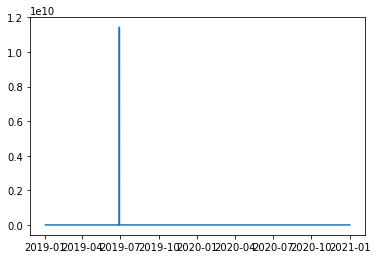

In [91]:
plt.plot(df.Close)

In [92]:
# example of concatenate two that changed name
if False:
    interval = "al"
    output_file_name = get_output_file_name(OUTPUT_FOLDER_NAME, "19-01-01", "20-12-31", "al", "AMRH")
    df1 = pd.read_pickle(output_file_name)
    df1

In [93]:
if False:
    interval = "al"
    output_file_name = get_output_file_name(OUTPUT_FOLDER_NAME, "20-12-31", "21-01-01", "al", "ENVB")
    df2 = pd.read_pickle(output_file_name)
    df2

In [94]:
if False:
    df = pd.concat([df1, df2], axis = 0)
    df

In [95]:
if False:
    output_file_name = get_output_file_name(OUTPUT_FOLDER_NAME, "19-01-01", "21-01-01", "al", "ENVB")
    df.to_pickle(output_file_name )

In [101]:
# sometimes buggy data with very large value in after-market, remove it
df = df[df.Close < 100000]

In [102]:
# get only the pre-market data
get_df_pre_market(df)

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2020-11-05 09:00:00-05:00,2020-11-05 08:55:00-05:00,1154.0200,1154.0200,1154.0200,1154.0200,0
2020-11-27 07:20:00-05:00,2020-11-27 07:18:00-05:00,1145.2400,1145.2400,1145.2400,1145.2400,0
2020-12-07 07:39:00-05:00,2020-12-07 07:38:00-05:00,1178.0000,1178.0000,1178.0000,1178.0000,0
2020-12-07 07:40:00-05:00,2020-12-07 07:39:00-05:00,1170.0000,1170.0000,1170.0000,1170.0000,0
2020-12-07 07:52:00-05:00,2020-12-07 07:51:00-05:00,1173.0000,1173.0000,1173.0000,1173.0000,0
2020-12-08 08:16:00-05:00,2020-12-08 08:15:00-05:00,1132.2407,1132.2407,1132.2407,1132.2407,0
2020-12-08 09:28:00-05:00,2020-12-08 09:27:00-05:00,1135.0000,1135.0000,1135.0000,1135.0000,0
2020-12-11 08:50:00-05:00,2020-12-11 08:49:00-05:00,1138.0000,1138.0000,1138.0000,1138.0000,0
2020-12-18 08:35:00-05:00,2020-12-18 08:34:00-05:00,1180.8900,1180.8900,1180.8900,1180.8900,0


In [103]:
# get only the after-market data
get_df_after_market(df)

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2019-01-08 18:30:00-05:00,2019-01-08 17:30:00-05:00,811.370,811.370,811.3700,811.370,0
2019-01-09 18:30:00-05:00,2019-01-09 17:30:00-05:00,820.360,820.360,820.3600,820.360,0
2019-01-16 18:30:00-05:00,2019-01-16 17:30:00-05:00,832.960,832.960,831.9904,832.960,0
2019-01-16 19:30:00-05:00,2019-01-16 18:30:00-05:00,832.960,832.960,832.9600,832.960,0
2019-01-23 18:30:00-05:00,2019-01-23 17:30:00-05:00,834.550,834.550,834.5500,834.550,0
...,...,...,...,...,...,...
2020-12-31 16:01:00-05:00,2020-12-31 16:00:00-05:00,1185.440,1185.440,1185.4400,1185.440,17742
2020-12-31 16:16:00-05:00,2020-12-31 16:15:00-05:00,1185.440,1185.440,1185.4400,1185.440,0
2020-12-31 16:17:00-05:00,2020-12-31 16:16:00-05:00,1185.441,1185.441,1185.4410,1185.441,0


In [104]:
# get only the during-market data
df2 = get_df_during_market(df)
df2

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2019-01-02 16:00:00-05:00,2019-01-02 09:30:00-05:00,831.669983,844.559998,829.010010,838.479980,333400
2019-01-03 16:00:00-05:00,2019-01-03 09:30:00-05:00,838.929993,850.859985,834.289978,845.580017,361600
2019-01-04 10:30:00-05:00,2019-01-04 09:30:00-05:00,851.390015,854.929993,844.580017,846.469971,0
2019-01-04 11:30:00-05:00,2019-01-04 10:30:00-05:00,848.623901,848.623901,834.950012,839.400024,49487
2019-01-04 12:30:00-05:00,2019-01-04 11:30:00-05:00,839.219971,840.710022,835.460022,840.210022,37657
...,...,...,...,...,...,...
2020-12-31 15:56:00-05:00,2020-12-31 15:55:00-05:00,1187.010010,1187.010010,1185.699951,1186.324951,1555
2020-12-31 15:57:00-05:00,2020-12-31 15:56:00-05:00,1186.810059,1186.979980,1186.810059,1186.839966,1822
2020-12-31 15:58:00-05:00,2020-12-31 15:57:00-05:00,1186.824951,1187.334961,1186.439941,1186.439941,4086


In [105]:
# for the in-market data, add a fictious interval one minute before that ends on the open value
# so that we can plot the open value as well
df3 = add_interval_with_open(df2)
df3

,datetime_start,Open,High,Low,Close,Volume
datetime_end,,,,,,
2019-01-02 09:30:00-05:00,2019-01-02 09:29:00-05:00,831.669983,831.669983,831.669983,831.669983,0
2019-01-02 16:00:00-05:00,2019-01-02 09:30:00-05:00,831.669983,844.559998,829.010010,838.479980,333400
2019-01-03 09:30:00-05:00,2019-01-03 09:29:00-05:00,838.929993,838.929993,838.929993,838.929993,0
2019-01-03 16:00:00-05:00,2019-01-03 09:30:00-05:00,838.929993,850.859985,834.289978,845.580017,361600
2019-01-04 09:30:00-05:00,2019-01-04 09:29:00-05:00,851.390015,851.390015,851.390015,851.390015,0
...,...,...,...,...,...,...
2020-12-31 15:56:00-05:00,2020-12-31 15:55:00-05:00,1187.010010,1187.010010,1185.699951,1186.324951,1555
2020-12-31 15:57:00-05:00,2020-12-31 15:56:00-05:00,1186.810059,1186.979980,1186.810059,1186.839966,1822
2020-12-31 15:58:00-05:00,2020-12-31 15:57:00-05:00,1186.824951,1187.334961,1186.439941,1186.439941,4086


In [106]:
final_plot = plot_interactive(df)
final_plot.opts(xaxis = "bottom", title = f"Stock price of {stock_ticker}", show_legend = False) 

:Overlay
   .Curve.I    :Curve   [datetime_end]   (Close)
   .Scatter.I  :Scatter   [datetime_end]   (Close)
   .Scatter.II :Scatter   [datetime_end]   (Close)

In [108]:
final_plot_volume = plot_interactive_volume(df)
xaxis = None # "bottom"
final_plot_volume.opts(xaxis = xaxis, yaxis = None, title = f"Stock volume of {stock_ticker}") 

:Bars   [datetime_end]   (Volume)